In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_41191/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [35]:
import math
import argparse
import h5py
import importlib
import numpy as np
import torch
import time
import sys
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from pointcloud.data.dataset import *
from pointcloud.utils.misc import *

from pointcloud.models.vae_flow import *
from pointcloud.models.flow import add_spectral_norm, spectral_norm_power_iteration
from pointcloud.configs import Configs
from pointcloud.utils.plotting import get_plots
from tqdm import tqdm


cfg = Configs()

print(cfg.__dict__)

seed_all(seed = cfg.seed)

{'name': 'kCaloClouds_', 'Acomment': 'baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-6', 'comet_project': 'k-CaloClouds', 'log_comet': True, 'model_name': 'epicVAE_nFlow_kDiffusion', 'latent_dim': 32, 'beta_1': 0.0001, 'beta_T': 0.02, 'sched_mode': 'quardatic', 'flexibility': 0.0, 'truncate_std': 2.0, 'latent_flow_depth': 14, 'latent_flow_hidden_dim': 256, 'num_samples': 4, 'features': 4, 'sample_num_points': 2048, 'kl_weight': 1e-06, 'residual': False, 'cond_features': 2, 'norm_cond': True, 'kld_min': 1.0, 'use_epic': False, 'epic_layers': 5, 'hidden_dim': 128, 'sum_scale': 0.001, 'weight_norm': True, 'flow_model': 'PiecewiseRationalQuadraticCouplingTransform', 'flow_transforms': 10, 'flow_layers': 2, 'flow_hidden_dims': 128, 'tails': 'linear', 'tail_bound': 10, 'dataset': 'x36_grid', 'dataset_path': '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5', 'quantized_pos': False, 'workers': 32, 'train_bs': 128,

In [36]:
# from pointcloud.models.allCond_epicVAE_nflow_PointDiff import AllCond_epicVAE_nFlow_PointDiff
# from pointcloud.models.epicVAE_nflows_kDiffusion import epicVAE_nFlow_kDiffusion

import pointcloud.models.epicVAE_nflows_kDiffusion as mdls
import pointcloud.models.allCond_epicVAE_nflow_PointDiff as mdls2
importlib.reload(mdls)
importlib.reload(mdls2)


# cfg.sched_mode = 'quardatic'
# cfg.num_steps = 100
# cfg.residual = True
# cfg.latent_dim = 256
# model = mdls2.AllCond_epicVAE_nFlow_PointDiff(cfg).to(cfg.device)
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic
# model.load_state_dict(checkpoint['state_dict'])




# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_24__14_54_09/ckpt_0.000000_500000.pt')
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_31__17_57_11/ckpt_0.000000_1700000.pt')

# cfg.model['sigma_data'] = 0.08
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_01__13_28_09/ckpt_0.000000_340000.pt')  # too wide cog_Y, too low hit_E

# RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_43_14/ckpt_0.000000_258000.pt')

# # RAdam optimizer, 2M iterations, scheduler from 300k-2M, EMApower 0.6667 - sigma_data=0.25
# cfg.model['sigma_data'] = 0.25
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__15_55_11/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=1e-4, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_40_41/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=True, lr=2e-3, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = True
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_36_04/ckpt_0.000000_920000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_03__10_24_31/ckpt_0.000000_737000.pt')

# # "sigma_data" : [0.08, 0.35, 0.08, 0.5]
# cfg.model['sigma_data'] = [0.08, 0.35, 0.08, 0.5]
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_27_15/ckpt_0.000000_300000.pt')

# # "sigma_data = 1
# cfg.model['sigma_data'] = 1.
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_28_38/ckpt_0.000000_280000.pt')

# # ""sigma_data = 0.1
# cfg.model['sigma_data'] = 0.1
# cfg.dropout_rate = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__13_34_50/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.05
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.05
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__14_21_41/ckpt_0.000000_320000.pt')

# # "sigma_data = 0.5, dropout=0.025
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.025
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_36_04/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.01
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.01
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_35_01/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=32
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__17_36_22/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=8
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 8
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__14_59_24/ckpt_0.000000_500000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=2
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 2
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__19_23_03/ckpt_0.000000_500000.pt')

# baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-5
cfg.model['sigma_data'] = 0.5
cfg.dropout_rate = 0.0
cfg.latent_dim = 32
checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__14_54_11/ckpt_0.000000_410000.pt')

# # baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-6
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__16_12_53/ckpt_0.000000_410000.pt')


model = mdls.epicVAE_nFlow_kDiffusion(cfg).to(cfg.device)
model.load_state_dict(checkpoint['others']['model_ema'])
# model.load_state_dict(checkpoint['state_dict'])

#  load model with torch load with name "model_ema


# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_570000.pt') #worst cog x
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_748000.pt') #best cog x

# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_sigmoid2023_04_06__16_35_47/ckpt_0.000000_849000.pt') # sigmoid 
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic



model.eval()

print('model loaded')

model loaded


/home/buhmae/6_PointCloudDiffusion/utils/misc.py:223: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  'mask': torch.range(0, cfg.latent_dim-1)<cfg.latent_dim//2


In [37]:
# TODO update dataloader such that not multiple events are taken again

cfg.val_bs = 32
cfg.workers = 1

# dataset_path =  '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/50GeV_x36_grid_regular_2k_Z4.hdf5'

train_dset = PointCloudDataset(
    file_path=cfg.dataset_path,
    bs=cfg.val_bs,
    quantized_pos=cfg.quantized_pos
)

dataloader = DataLoader(
    train_dset,
    batch_size=1,
    num_workers=cfg.workers,
    shuffle=cfg.shuffle
)

In [38]:
# generate from data loop
max_events = 2000

encoded_z_list, flow_z_list = [], []
mu_list, logvar_list = [], []

# max_iters = int(len(dataloader) / cfg.val_bs)
max_iters = int(max_events / cfg.val_bs + 1)
for _ in tqdm(range(max_iters)):
    batch = next(iter(dataloader))
    x = batch['event'][0].float().to(cfg.device)  # B,N,d
    e = batch['energy'][0].float().to(cfg.device)  # B,1
    n = batch['points'][0].float().to(cfg.device)  # B,1
    # conditioning feature vector --> scale featuers to [-1,1] and concat
    if cfg.norm_cond:
        e = e / 100 * 2 -1   # max incident energy: 100 GeV
        n = n / cfg.max_points * 2  - 1
    cond_feats = torch.cat([e,n], -1)  # B,2

    with torch.no_grad():
        z_mu, z_logvar = model.encoder(x, cond_feats)
        encoded_z = reparameterize_gaussian(mean=z_mu, logvar=z_logvar)  # (B, F)
        
        # w = torch.randn([cfg.val_bs, cfg.latent_dim], device=cfg.device)
        # flow_z = model_flow(w, cond_feats, reverse=True).view(cfg.val_bs, -1)
        flow_z = model.flow.sample(context=cond_feats, num_samples=1).view(cfg.val_bs, cfg.latent_dim)

    encoded_z_list.append(encoded_z.cpu().numpy())
    flow_z_list.append(flow_z.cpu().numpy())
    mu_list.append(z_mu.cpu().numpy())
    logvar_list.append(z_logvar.cpu().numpy())

encoded_z = np.vstack(encoded_z_list)[:max_events]
flow_z = np.vstack(flow_z_list)[:max_events]
mu = np.vstack(mu_list)[:max_events]
logvar = np.vstack(logvar_list)[:max_events]

  0%|          | 0/63 [00:00<?, ?it/s]/beegfs/desy/user/buhmae/conda/envs/torch_113/lib/python3.8/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(
100%|██████████| 63/63 [00:16<00:00,  3.91it/s]


In [39]:
print(encoded_z.shape, flow_z.shape)
print(encoded_z.min(), flow_z.min())
print(encoded_z.max(), flow_z.max())

# calculate KLD per latent dimension
kdlloss = KLDloss()
kld = [kdlloss(torch.from_numpy(mu[:,i]), torch.from_numpy(logvar[:,i])) for i in range(cfg.latent_dim)]
kld = np.array(kld)

# sort kld from high to low
sortmask = np.argsort(kld)[::-1]
kld = kld[sortmask]

print('KLD sorted: ', kld)
print('KLD sum:', kld.sum())

encoded_z = encoded_z[:,sortmask]
flow_z = flow_z[:,sortmask]
mu = mu[:,sortmask]
logvar = logvar[:,sortmask]


(2000, 32) (2000, 32)
-5.4549255 -4.1945887
4.237935 4.323087
KLD sorted:  [3.6341248e+00 2.5520282e+00 2.0466635e+00 1.6202691e+00 7.5038651e-04
 7.4672431e-04 7.0233253e-04 6.9711963e-04 6.9659337e-04 6.8467774e-04
 6.7866477e-04 6.7582546e-04 6.7509705e-04 6.7190488e-04 6.5417506e-04
 6.5058994e-04 6.5036980e-04 6.4742920e-04 6.4038060e-04 6.4003729e-04
 6.3773256e-04 6.3737098e-04 6.3711702e-04 6.3262391e-04 6.2864419e-04
 6.2574551e-04 6.2098174e-04 6.1780162e-04 6.1650656e-04 6.1204087e-04
 6.0569443e-04 6.0348242e-04]
KLD sum: 9.871424


100%|██████████| 32/32 [00:00<00:00, 50.99it/s]


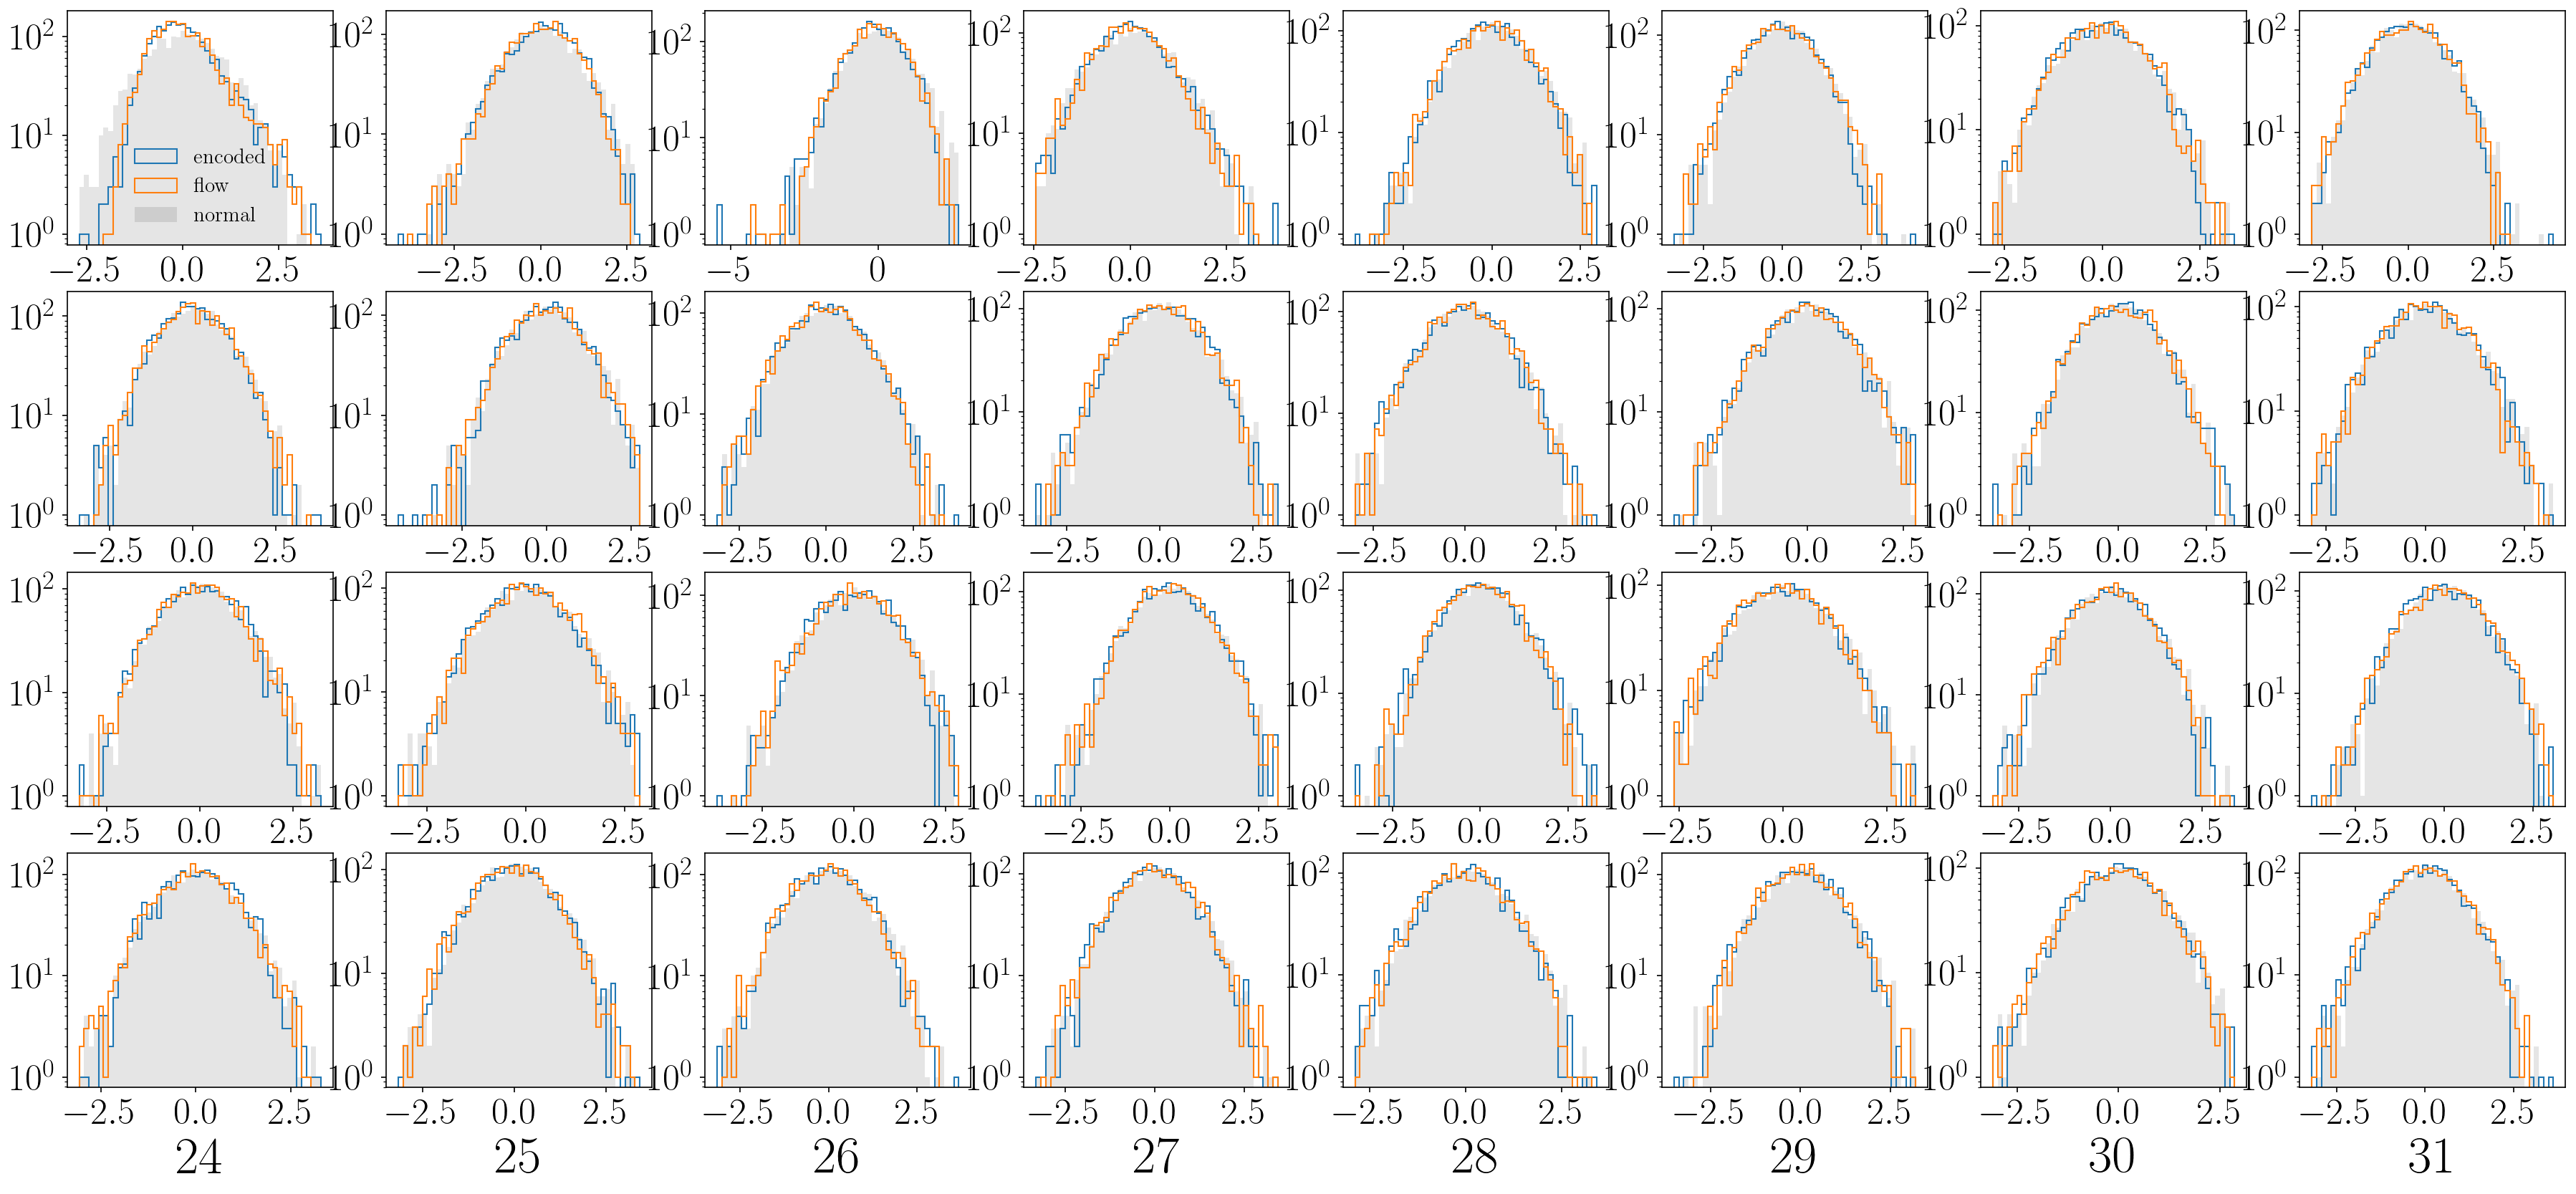

In [40]:
fig = plt.figure(figsize=(30, 30), facecolor='none', dpi=150)
gs = GridSpec(9,8)

normal = np.random.normal(size=(max_events, 1))

# for i in tqdm(range(encoded_z.shape[1])):
for i in tqdm(range(32)):

    ax = fig.add_subplot(gs[i])
    h0 = ax.hist(encoded_z[:,i], bins=50, histtype='step', label='encoded')
    h1 = ax.hist(flow_z[:,i], bins=h0[1], histtype='step', label='flow')
    h2 = ax.hist(normal, bins=h0[1], histtype='stepfilled', label='normal', alpha=0.1, color='k')
    ax.set_xlabel(str(i))

    if i == 0: 
        ax.legend(loc='best', fontsize=14)

    ax.set_yscale('log')

plt.show()

In [41]:
print(mu.mean(0))


[ 5.4170810e-02  7.3310181e-02 -1.2525451e-01  5.3387124e-02
  6.9246860e-04  2.4721702e-04  5.8531546e-04  1.9479003e-03
  1.2242384e-06  1.6236317e-04  5.4970098e-04 -8.0954132e-04
 -2.1136891e-04  4.1641941e-04 -6.4279058e-04  1.2946453e-04
  1.4995816e-03 -9.8832906e-04  2.5437720e-04  1.7756310e-04
  2.3033583e-04 -3.6903453e-04  8.4382476e-04 -5.7107105e-04
 -1.4174011e-03  8.4893632e-04 -5.2622380e-04  3.3000728e-05
 -1.5151560e-03  8.7634462e-04 -7.7532408e-05  4.7253596e-04]


In [42]:
print(logvar.mean(0))

[-7.543657   -5.192053   -4.2211957  -3.391583   -0.05157395 -0.0524321
 -0.0523665  -0.05105802 -0.05124574 -0.05115433 -0.05201841 -0.0524096
 -0.05174692 -0.05166335 -0.05134579 -0.05113593 -0.05126137 -0.05115706
 -0.05041417 -0.05086098 -0.05081568 -0.05070386 -0.05065255 -0.05063539
 -0.0503877  -0.0504078  -0.05003543 -0.05007744 -0.04999414 -0.04985343
 -0.04941156 -0.04935484]
